In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import polars as pl
import aiohttp
from tqdm.asyncio import tqdm

import compute_compliance

In [5]:
# load in the data
df = (pl
      .read_csv('paylesshealth/hospitals.csv')

    # some of the cdm_urls are like 
    # url1|url2 so we need to explode those out
    # into separate rows

      .with_column(
        pl.col('cdm_url').str.split('|'))
      .explode('cdm_url'))

In [6]:
async with aiohttp.ClientSession(raise_for_status = True) as session:
        t = df.sample(100, seed=234)
        cols = ['gross_chk', 'minmax_chk', 'cash_chk', 'generic_chk', 'insurer_chk', 'filename_chk', 'err']
        t[cols] = await tqdm.gather(*(compute_compliance.checker(session, url) for url in t['cdm_url']))

        # Add up all the values (except the error col) where the col equals 1
        t = t.with_column(
            pl.fold(pl.lit(0), lambda score, v: score + v.is_in([1]), cols[:-1]).alias('score')
        )

        t = t.sort('score')

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
t

ccn,name,state,city,homepage,cdm_indirect_url,cdm_url,gross_chk,minmax_chk,cash_chk,generic_chk,insurer_chk,filename_chk,err,score
str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64
"""371341""","""SHARE MEDICAL ...","""OK""","""ALVA""","""https://www.sm...","""https://www.sm...","""https://irp-cd...",0,0,0,0,0,0,0,0
"""210037""","""UNIVERSITY OF ...","""MD""","""EASTON""","""https://www.um...","""https://www.um...","""https://www.um...",0,0,0,0,0,0,3,0
"""370192""","""NORTHWEST SURG...","""OK""","""OKLAHOMA CITY""","""https://nwsurg...","""https://nwsurg...","""https://nwsurg...",0,0,0,0,0,0,0,0
"""03007F""","""US ARMY HOSP""","""AZ""","""FORT HUACHUCA""",null,null,null,0,0,0,0,0,0,1,0
"""390048""","""GEISINGER-LEWI...","""PA""","""LEWISTOWN""","""https://www.ge...","""https://www.ge...","""https://www.ge...",0,0,0,0,0,0,0,0
"""021302""","""PROVIDENCE SEW...","""AK""","""SEWARD""","""https://www.pr...","""https://www.pr...","""https://www.pr...",0,0,0,0,0,0,3,0
"""150074""","""COMMUNITY HOSP...","""IN""","""INDIANAPOLIS""","""https://www.ec...","""https://www.ec...","""https://search...",0,0,0,0,0,0,0,0
"""111323""","""OPTIM MEDICAL ...","""GA""","""REIDSVILLE""","""https://optimh...","""https://optimh...","""https://optimh...",1,-1,1,1,1,-1,0,4
"""440046""","""TRISTAR HORIZO...","""TN""","""DICKSON""","""https://www.tr...","""https://www.tr...","""https://hcah-p...",1,-1,1,1,-1,1,0,4


In [ ]:
t.write_csv('result.csv')

In [ ]:
# t = await compute_compliance.check(df)

<AxesSubplot:>

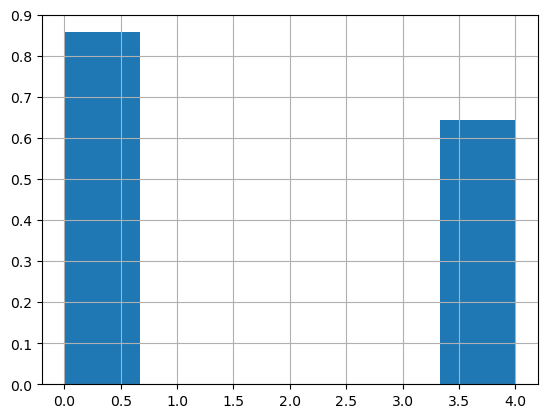

In [ ]:
(t
    .filter(pl.col('err').is_in([0]))
    # .filter(pl.col('score').is_in([0,1,2,3,4,5,6]))
    .to_pandas()['score']
    .hist(bins = 6, density = True)
)